# Covariate data preprocessing

1. **This tutorial are for the factor analysis and PCA modules of the following flowchart**
2. **Each commands in this tutorials should be run once per theme**



## Factor analysis
1. Factor analysis can be done using one of the following method:PEER & APEX (BiCV).
2. Both factor analysis method can run with or without covariate file input.
3. No need to run both.


## PCA
The PCA was done based on the related/unrelated samples generated in the genotype_preprocessing step. PCs was estimated based on the unrelated sample, then the PCs for related sample will be calculated based on the estimated eigen loading from the unrelated sample. The PCs with a cumulative PVE of 70% will be used in determined outliner and used in downstream analysis.

In [ ]:
sos run pipeline/PCA.ipynb flashpca \
   --cwd output/data_preprocessing/MWE/pca output/data_preprocessing/MWE/pca \
   --genoFile data_preprocessing/MWE/genotype_data/MWE.MWE.unrelated.filtered.prune.bed \
   --container containers/flashpcaR.sif

> /mnt/mfs/statgen/snuc_pseudo_bulk/eight_tissue_analysis/MWE/QTL_association/output/data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.scree.png (56.7 KiB):

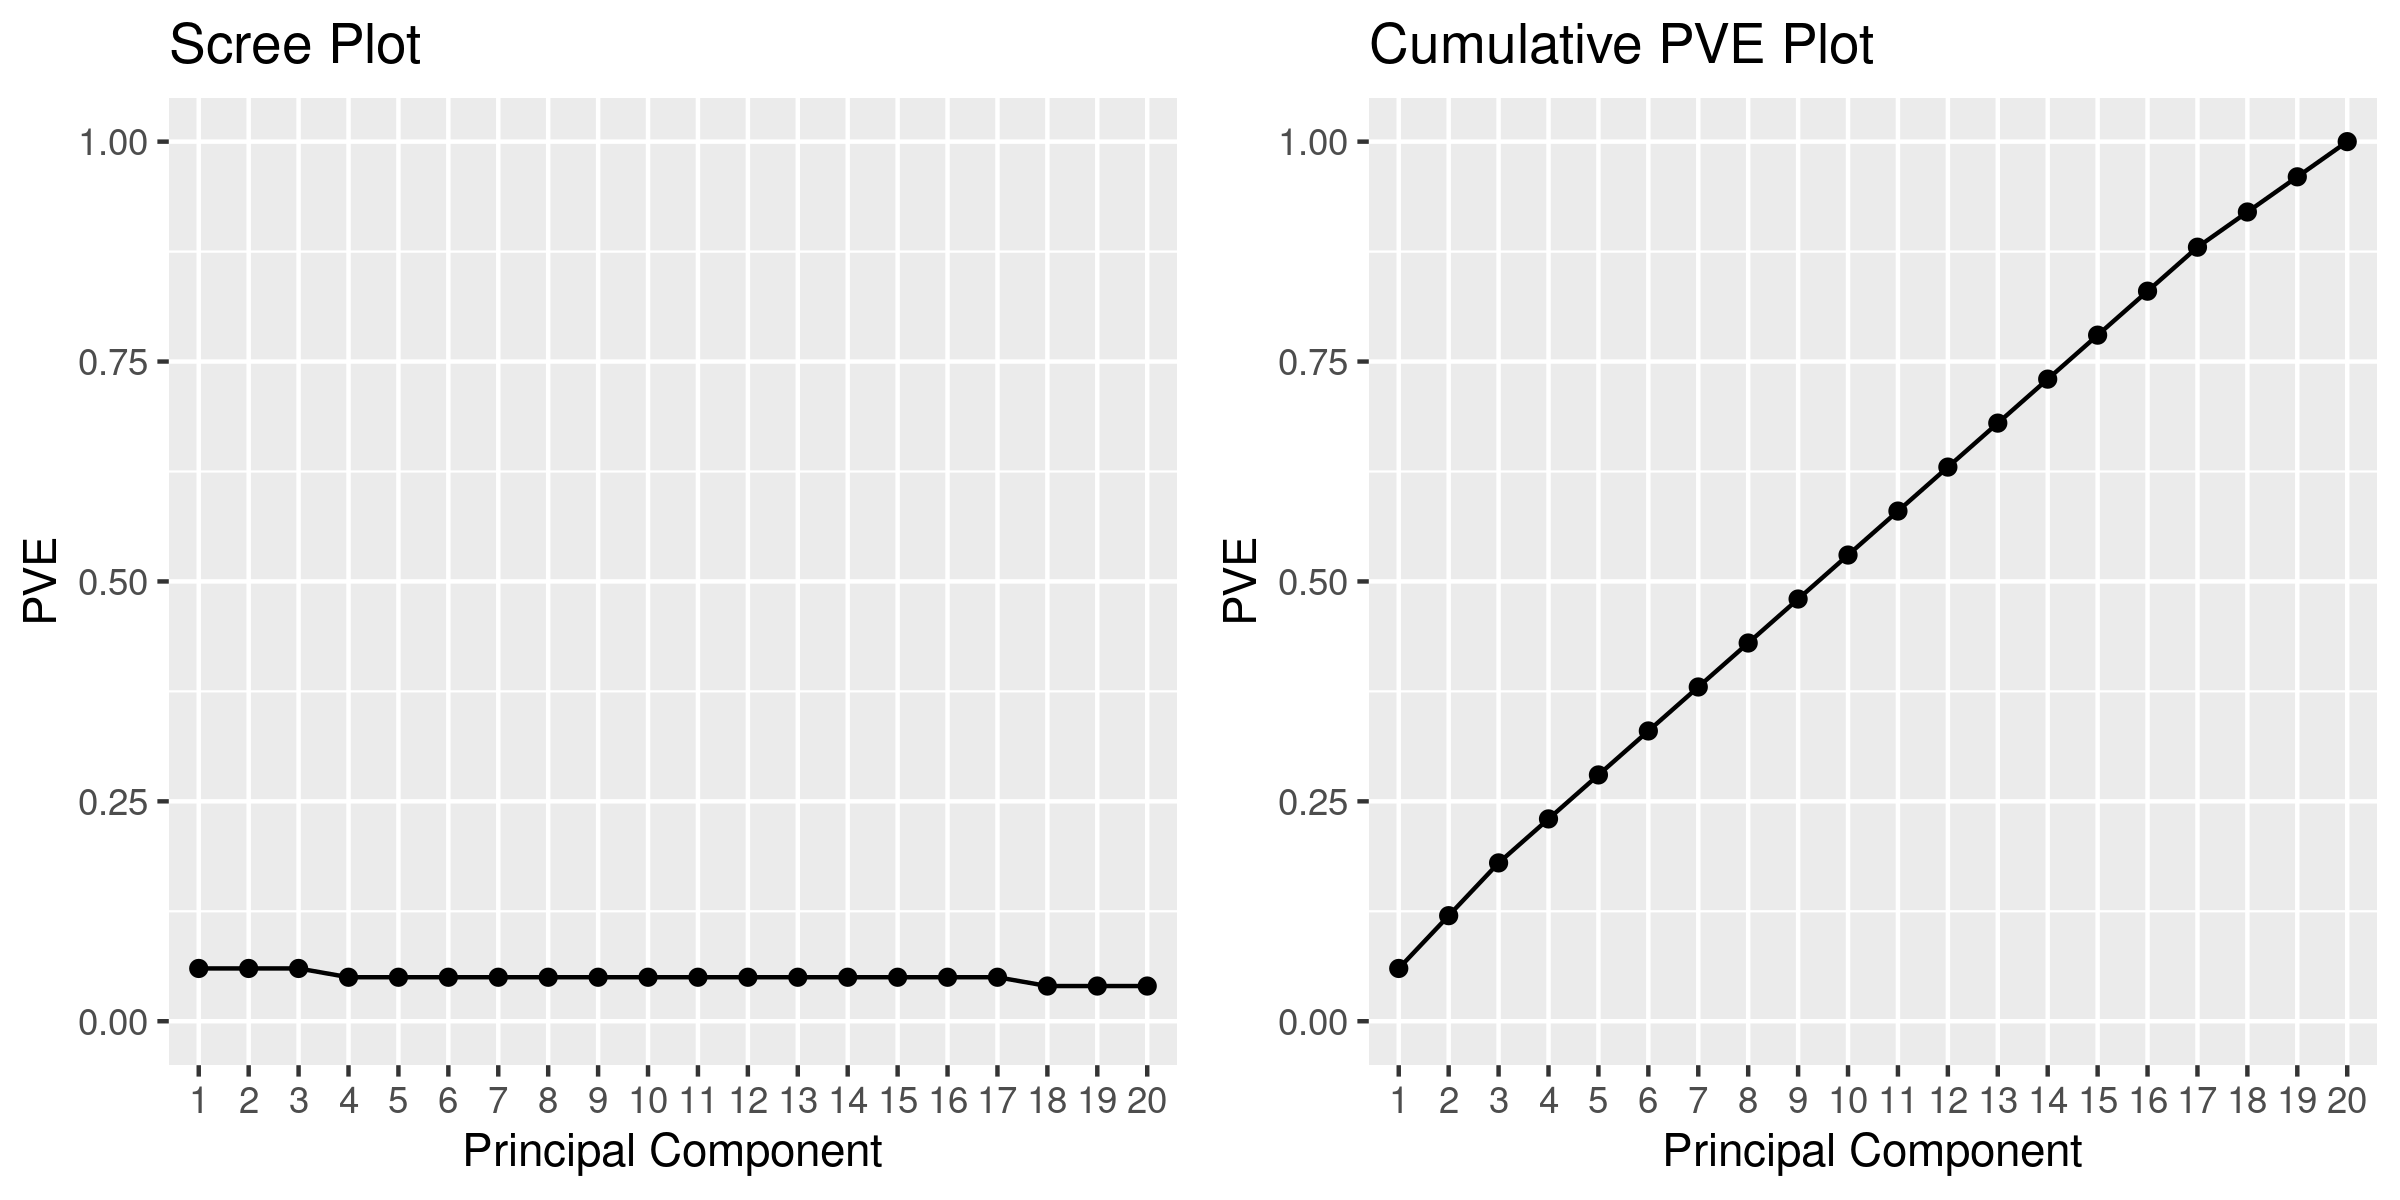

In [1]:
%preview data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.scree.png

In [ ]:
sos run pipeline/PCA.ipynb project_samples \
        --cwd output/data_preprocessing/MWE/pca output/data_preprocessing/MWE/pca \
        --genoFile data_preprocessing/MWE/genotype_data/MWE.MWE.related.filtered.extracted.bed \
        --pca-model  output/data_preprocessing/MWE/pca/MWE.MWE.unrelated.filtered.prune.pca.rds \
        --maha-k `awk '$3 < 0.7' output/data_preprocessing/MWE/pca/MWE.MWE.unrelated.filtered.prune.pca.scree.txt | tail -1 | cut -f 1  ` \
        --container containers/flashpcaR.sif

> /mnt/mfs/statgen/snuc_pseudo_bulk/eight_tissue_analysis/MWE/QTL_association/output/data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.pc.png (1.5 MiB):

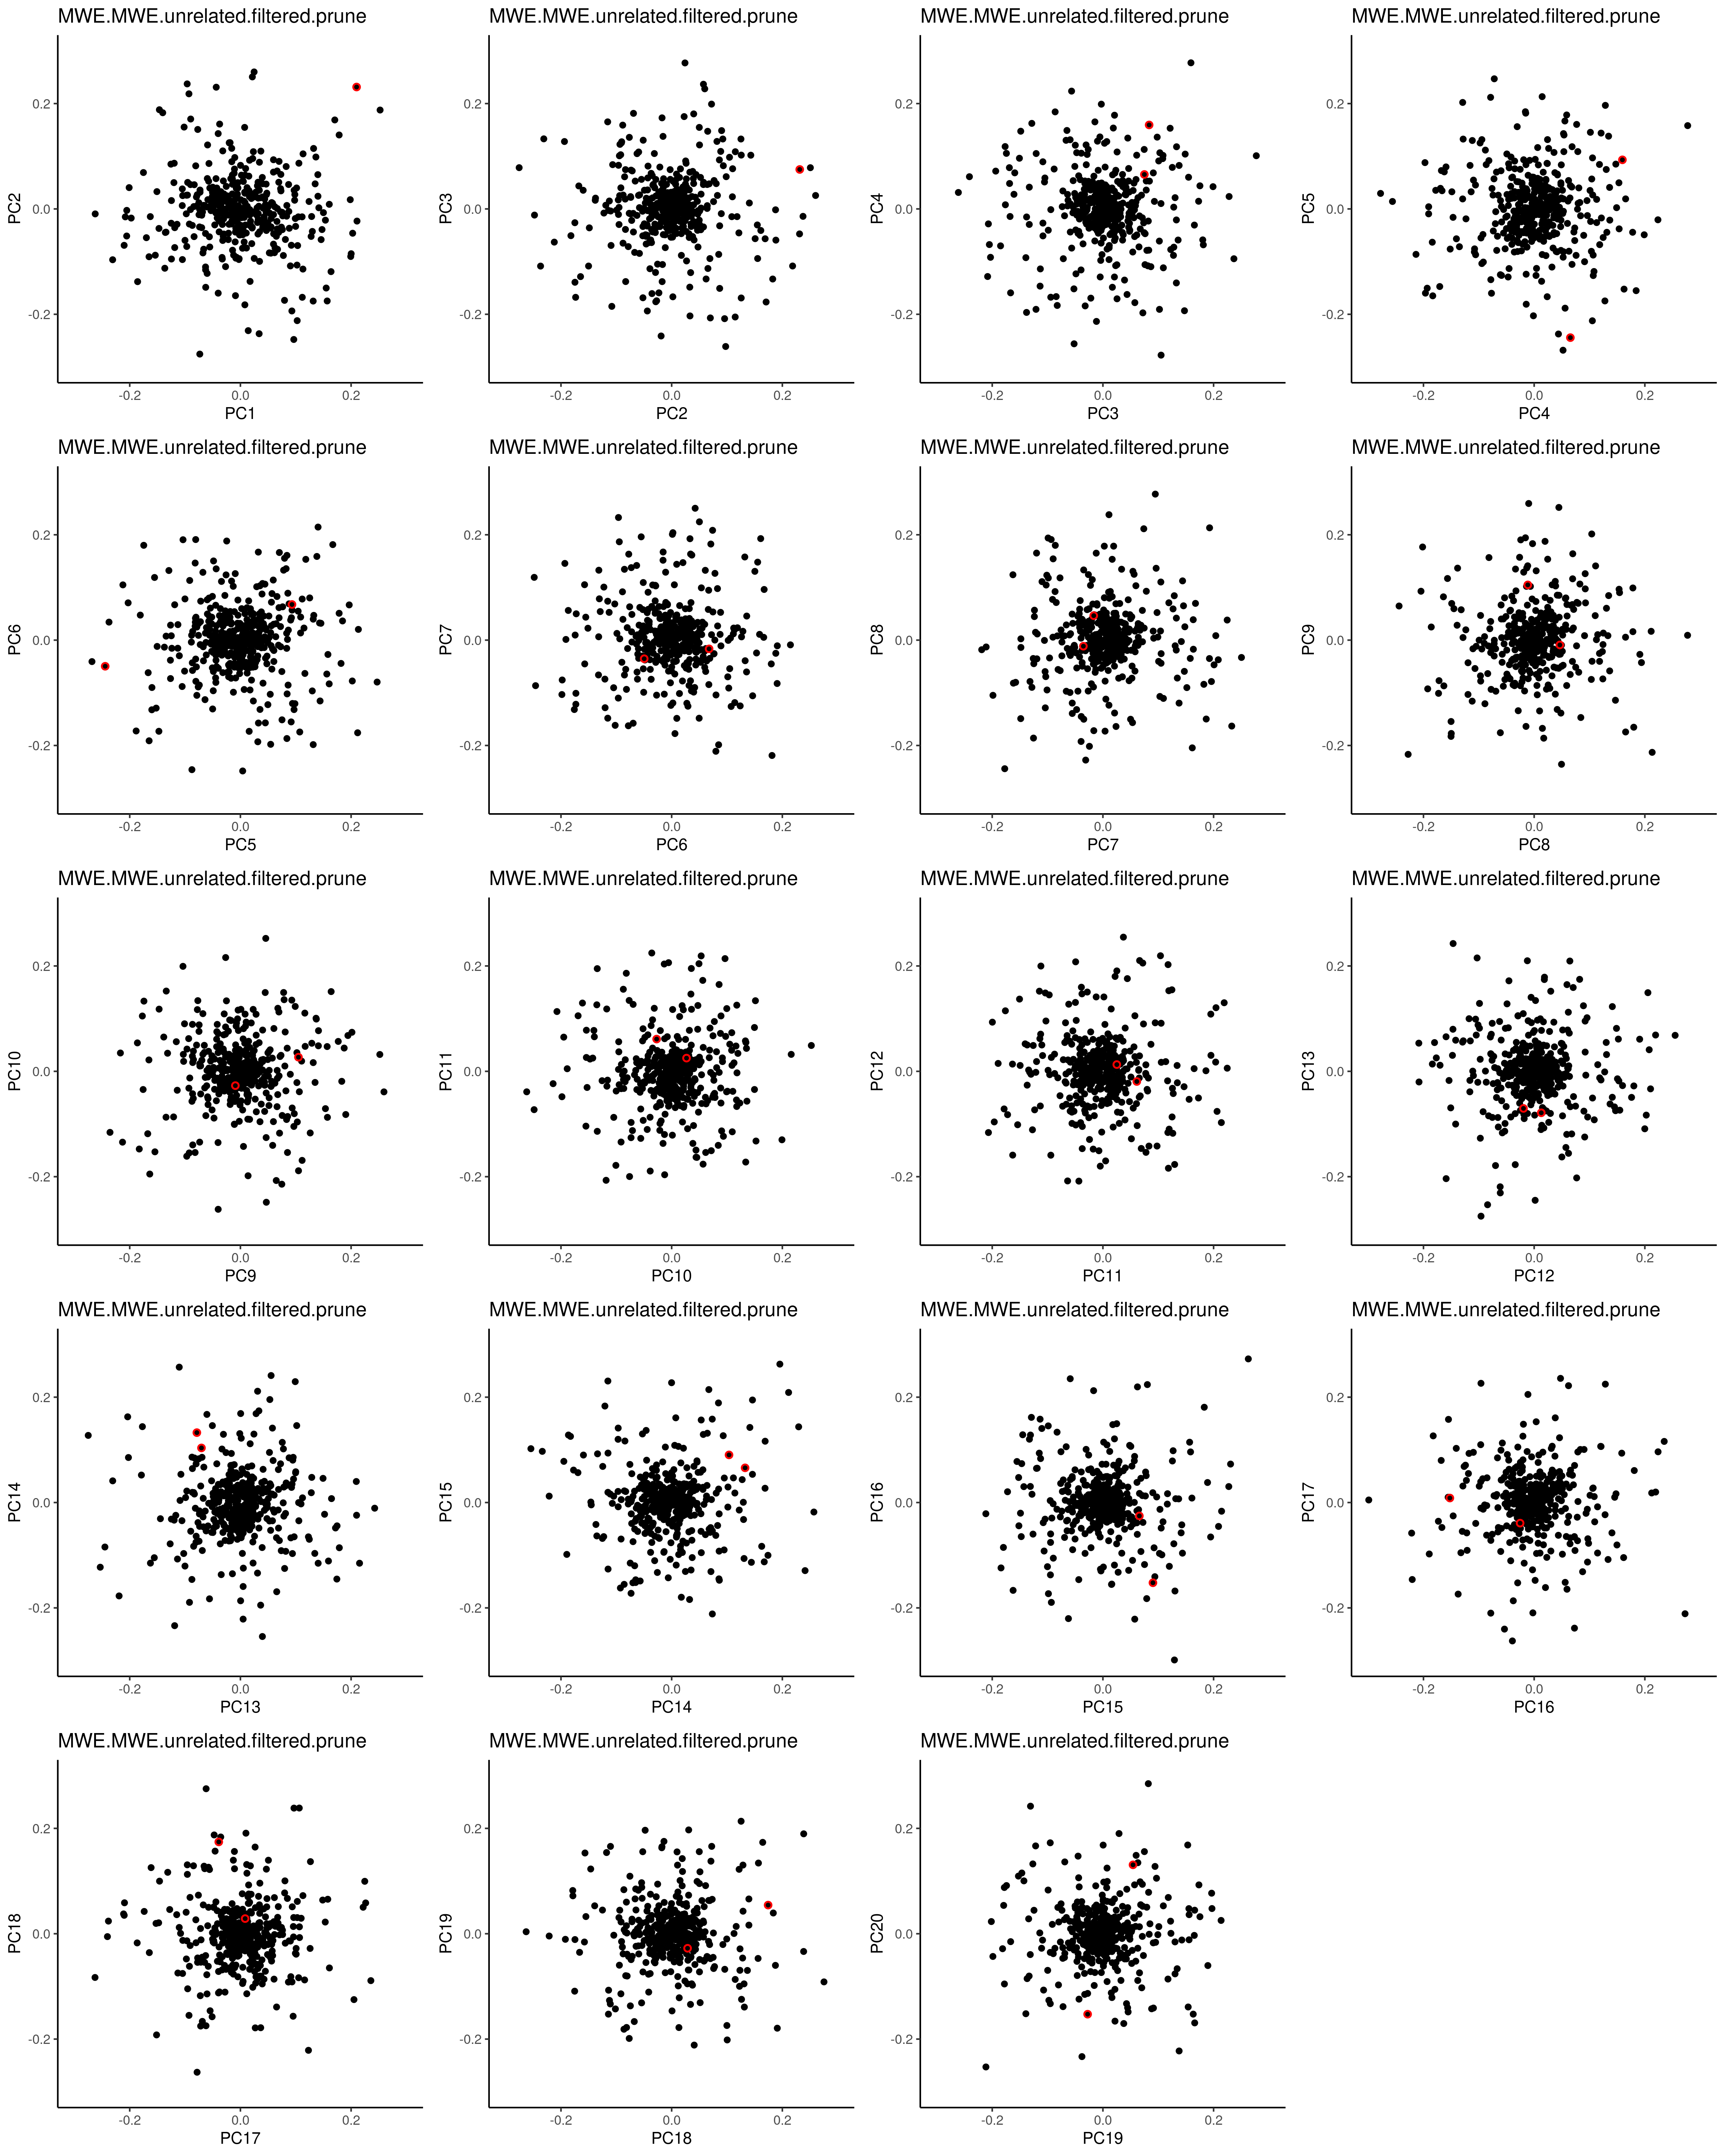

In [2]:
%preview data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.pc.png

## Merge covariate
The tolerance for sample-wide NA rate of any covariates/pc are specified by `tol_cov`.  -1 means quit, otherwise for covariate with missing rate larger than tol_cov will be removed, with missing rate smaller than tol_cov will be mean_imputed.

The first k PCs that satisfied >70% PVE will be merged with the covariates for downstream analysis and for estimating the residual expression in the `phenotype_preprocessing` section.

In [ ]:
sos run pipeline/covariate_formatting.ipynb merge_pca_covariate \
        --cwd output/data_preprocessing/MWE/covariates \
        --pcaFile data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.rds \
        --covFile  MWE.covariate.cov.gz \
        --tol_cov 0.3  \
        --k `awk '$3 < 0.7' output/data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.scree.txt | tail -1 | cut -f 1 ` \
        --container containers/bioinfo.sif

## Factor Analysis
The residual expression will then be used to conduct the factor analysis using either BiCV (APEX) or PEER (MOFA2)

In [ ]:
sos run pipeline/BiCV_factor.ipynb BiCV \
   --cwd output/data_preprocessing/MWE/covariates \
   --phenoFile data_preprocessing/MWE/phenotype/MWE.log2cpm.MWE.covariate.cov.MWE.MWE.related.filtered.extracted.pca.projected.resid.bed.gz  \
   --container containers/APEX.sif  \
   --walltime 24h \
   --numThreads 8 \
   --iteration 1000 \
   --N 10

In [ ]:
sos run pipeline/PEER_factor.ipynb PEER \
   --cwd output/data_preprocessing/MWE/covariates \
   --phenoFile data_preprocessing/MWE/phenotype/MWE.log2cpm.MWE.covariate.cov.MWE.MWE.related.filtered.extracted.pca.projected.resid.bed.gz  \
   --container containers/PEER.sif  \
   --walltime 24h \
   --numThreads 8 \
   --iteration 1000 \
   --N 10

## Merged factor & covariates
The factors estimated above will be merged with pc-cov for downstream analysis.

In [ ]:
sos run pipeline/covariate_formatting.ipynb merge_factor_covariate \
        --cwd output/data_preprocessing/MWE/covariates \
        --factorFile data_preprocessing/MWE/covariates/MWE.log2cpm.MWE.covariate.cov.MWE.MWE.related.filtered.extracted.pca.projected.resid.bed.PEER.cov.gz \
        --covFile  data_preprocessing/MWE/covariates/MWE.covariate.cov.MWE.MWE.related.filtered.extracted.pca.projected.gz \
        --container containers/bioinfo.sif